# GP-Circular

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Circular domains are a challenge for Gaussian Processes. 

* Periodic patterns are assumed, but they are hard to capture with primitives
* For circular domain $[0, \pi)$ how to model correlation between $\pi-\varepsilon$ and $\varepsilon$, real distance is $2\varepsilon$, but computes differently if you just treat it non circular $(\pi-\varepsilon) - \varepsilon$
* For correctly computed distances we need to verify kernel we obtain is positive definite

**An alternative approach is required.**


In the following [paper](https://hal.archives-ouvertes.fr/hal-01119942v1/document), the Weinland function is used to solve the problem and ensures positive definite kernel on the circular domain (and not only).

$$
W_c(t) = \left(1 + \tau \frac{t}{c}\right)\left(1-\frac{t}{c}\right)_+^\tau
$$
where $c$ is maximum value for $t$ and $\tau\ge 4$ is some positive number 

The kernel itself for geodesic distance (arc length) on a circle looks like

$$
k_g(x, y) = W_\pi(\text{dist}_{\mathit{geo}}(x, y))
$$

Briefly, you can think

* $t$ is time, it runs from $0$ to $24$ and then goes back to $0$
* $c$ is maximum distance between any timestamps, here it would be $12$
* $\tau$ is proportional to the correleation strength. Let's see how much!

In python the Weinland function is implemented like this

In [3]:
def weinland(t, c, tau=4):
    return (1 + tau * t / c) * np.clip(1 - t / c, 0, np.inf) ** tau

We also need implimentation for the distance on a circular domain

In [4]:
def angular_distance(x, y, c):
    # https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles
    return (x - y + c) % (c * 2) - c

In [5]:
C = np.pi
x = np.linspace(0, C)

Let's visualize what the Weinland function is, and how it affects the kernel:

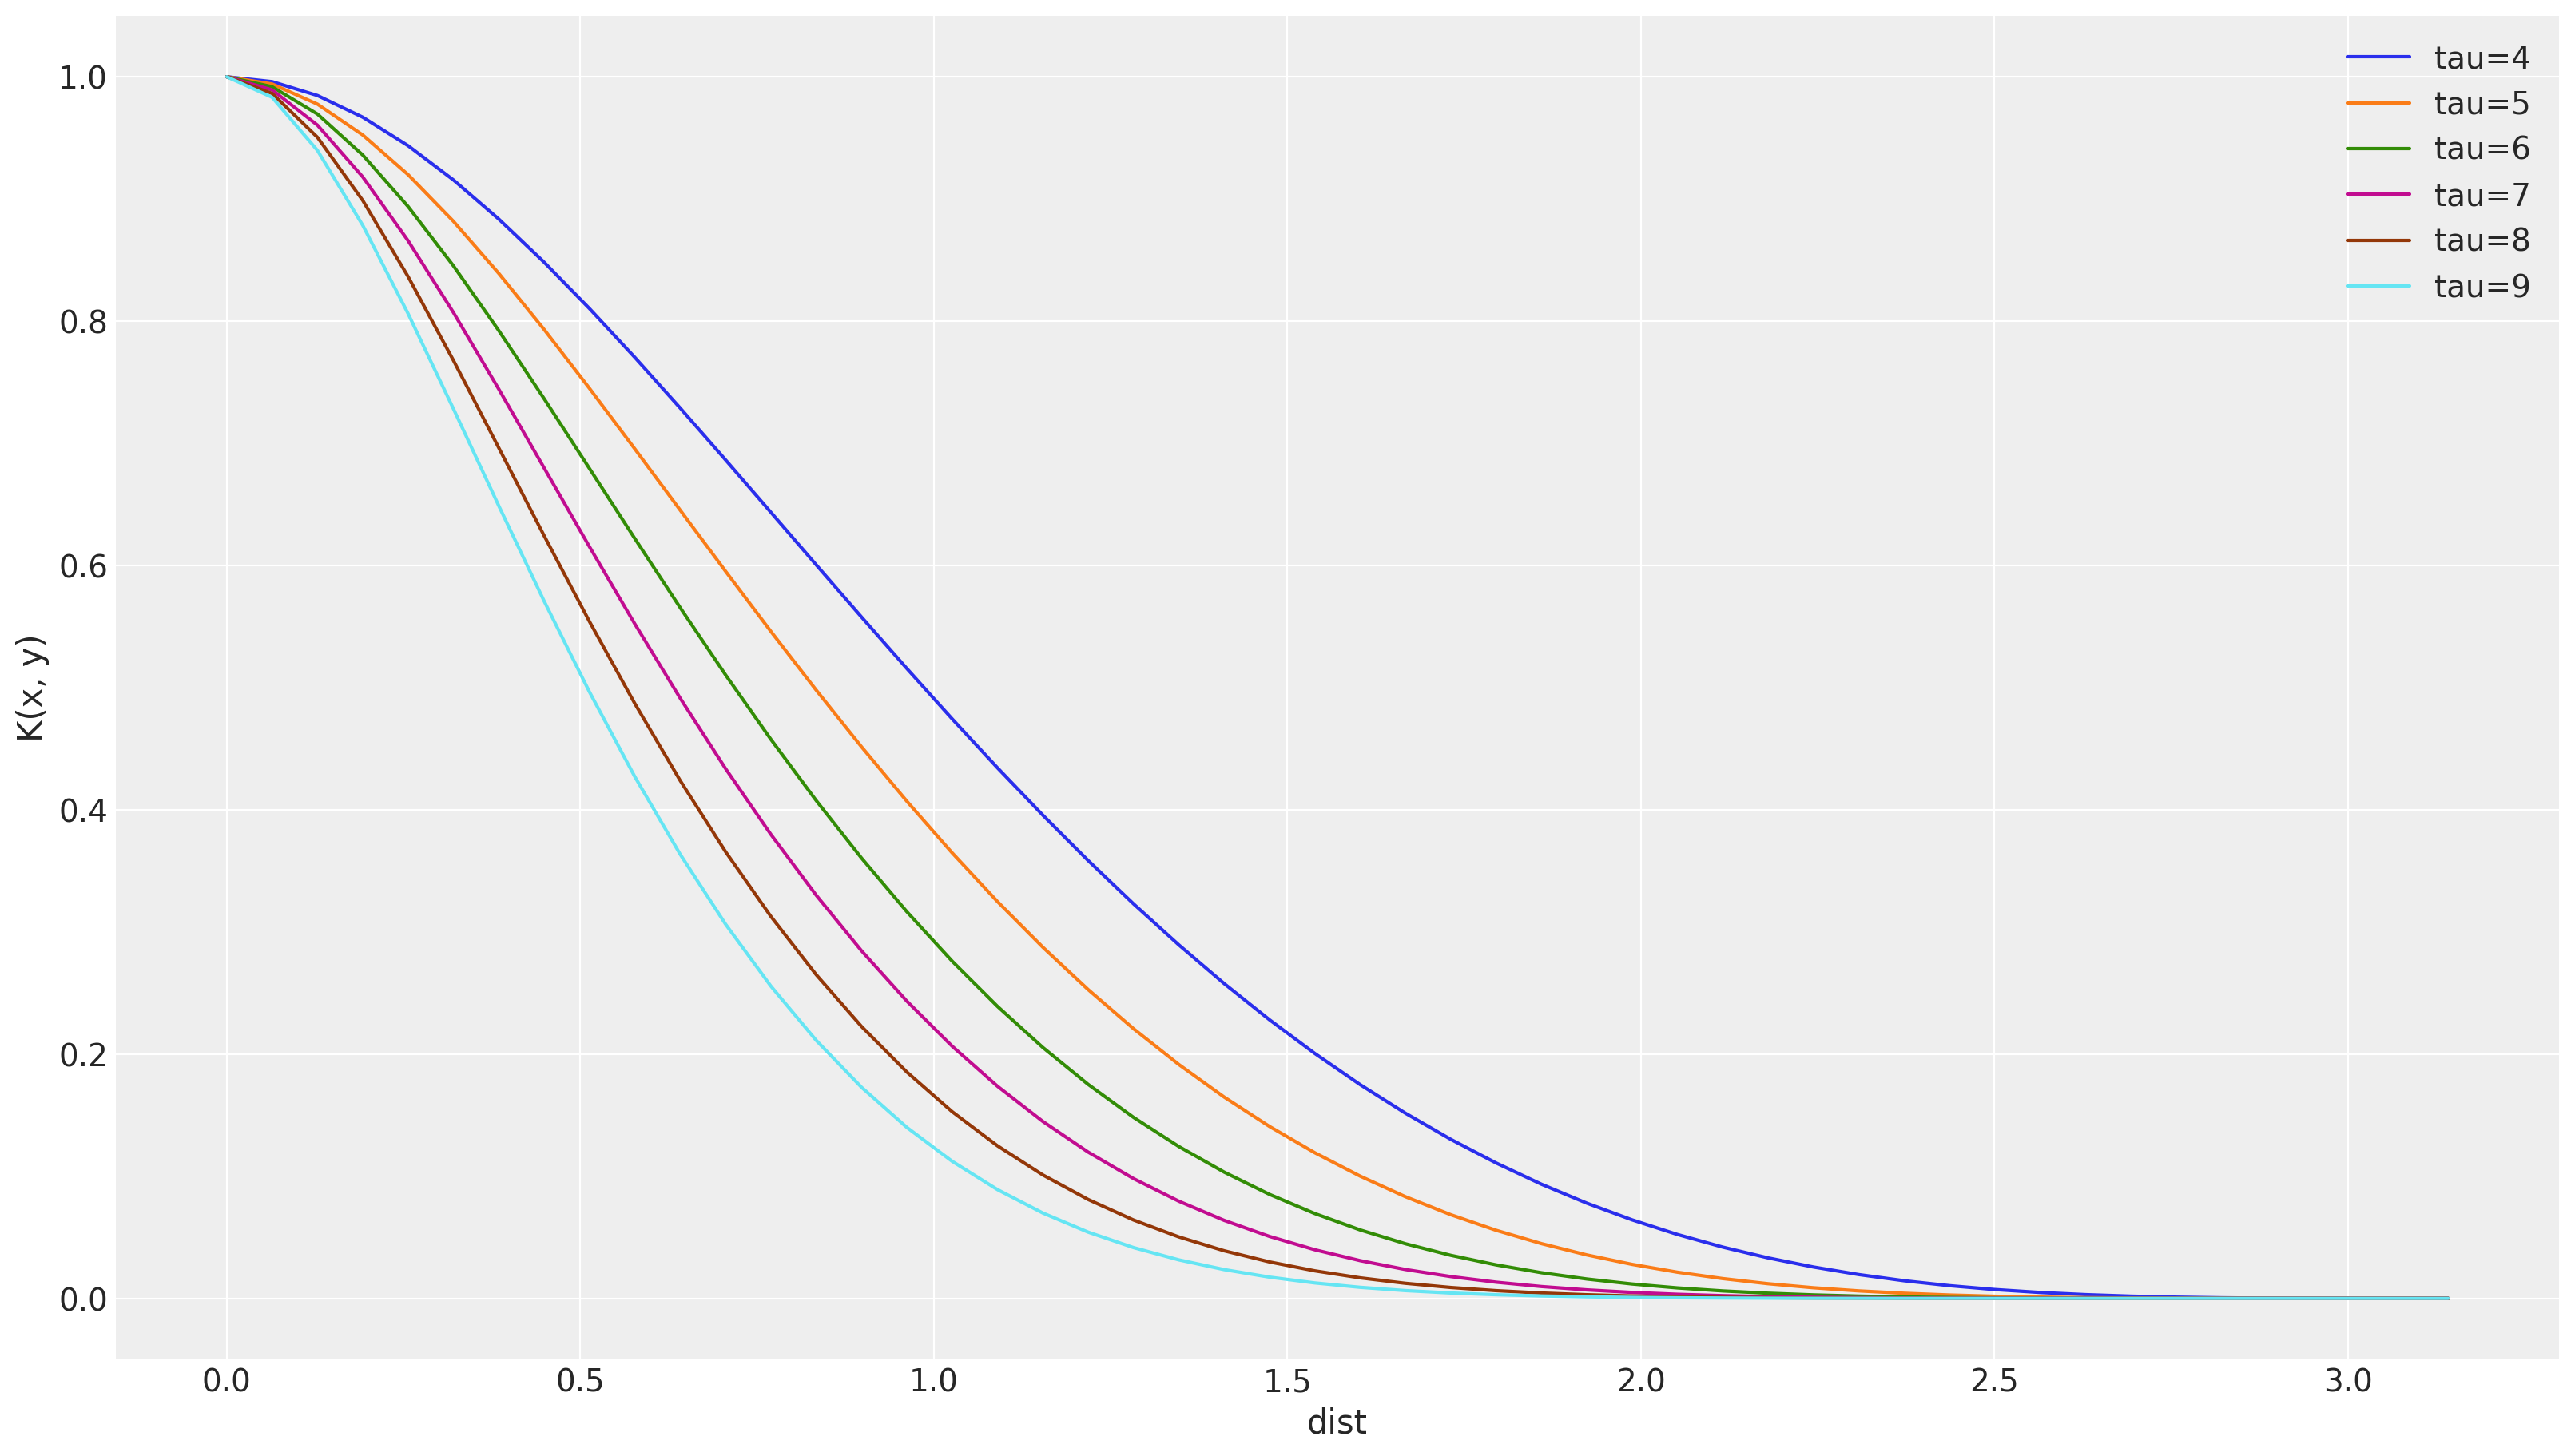

In [6]:
plt.figure(figsize=(16, 9))
for tau in range(4, 10):
    plt.plot(x, weinland(x, C, tau), label=f"tau={tau}")
plt.legend()
plt.ylabel("K(x, y)")
plt.xlabel("dist");

As we see, the higher $\tau$ is, the less correlated the samples

Also, let's validate our circular distance function is working as expected

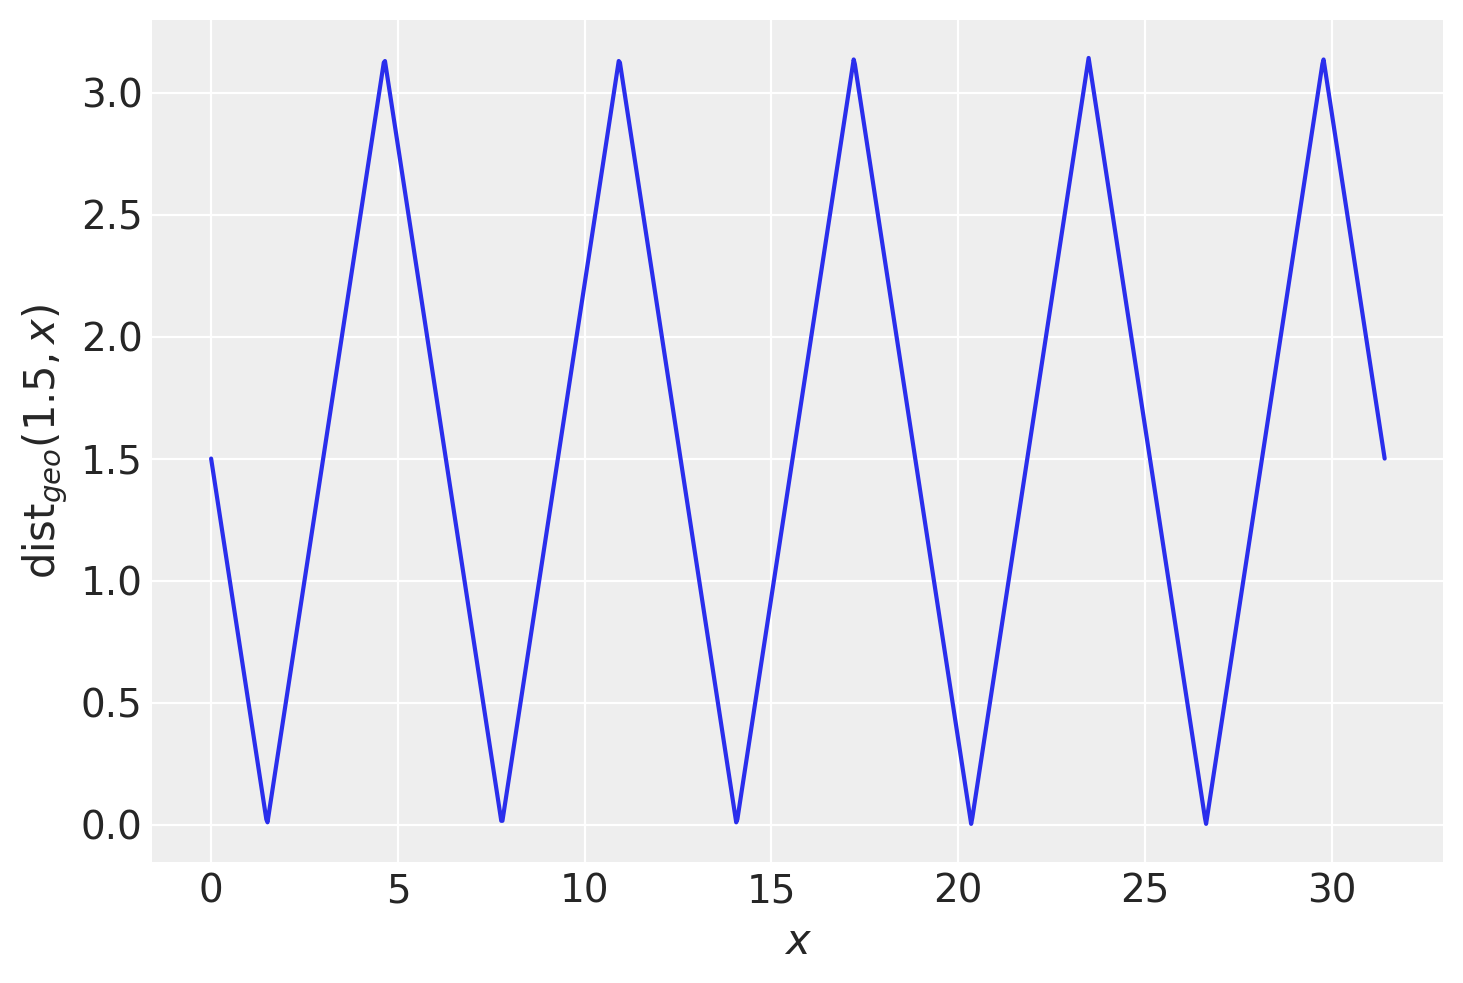

In [7]:
plt.plot(
    np.linspace(0, 10 * np.pi, 1000),
    abs(angular_distance(np.linspace(0, 10 * np.pi, 1000), 1.5, C)),
)
plt.ylabel(r"$\operatorname{dist}_{geo}(1.5, x)$")
plt.xlabel("$x$");

In pymc3 we will use `pm.gp.cov.Circular` to model circular functions

In [8]:
angles = np.linspace(0, 2 * np.pi)
observed = dict(x=np.random.uniform(0, np.pi * 2, size=5), y=np.random.randn(5) + 4)


def plot_kernel_results(Kernel):
    """
    To check for many kernels we leave it as a parameter
    """
    with pm.Model() as model:
        cov = Kernel()
        gp = pm.gp.Marginal(pm.gp.mean.Constant(4), cov_func=cov)
        lik = gp.marginal_likelihood("x_obs", X=observed["x"][:, None], y=observed["y"], noise=0.2)
        mp = pm.find_MAP()
        # actual functions
        y_sampled = gp.conditional("y", angles[:, None])
        # GP predictions (mu, cov)
        y_pred = gp.predict(angles[:, None], point=mp)
        trace = pm.sample_posterior_predictive([mp], var_names=["y"], samples=100)
    plt.figure(figsize=(9, 9))
    paths = plt.polar(angles, trace["y"].T, color="b", alpha=0.05)
    plt.scatter(observed["x"], observed["y"], color="r", alpha=1, label="observations")
    plt.polar(angles, y_pred[0], color="black")
    plt.fill_between(
        angles,
        y_pred[0] - np.diag(y_pred[1]) ** 0.5,
        y_pred[0] + np.diag(y_pred[1]) ** 0.5,
        color="gray",
        alpha=0.5,
        label=r"$\mu\pm\sigma$",
    )
    plt.fill_between(
        angles,
        y_pred[0] - np.diag(y_pred[1]) ** 0.5 * 3,
        y_pred[0] + np.diag(y_pred[1]) ** 0.5 * 3,
        color="gray",
        alpha=0.25,
        label=r"$\mu\pm3\sigma$",
    )
    plt.legend()

In [9]:
def circular():
    tau = pm.Deterministic("τ", pm.Gamma("_τ", alpha=2, beta=1) + 4)
    cov = pm.gp.cov.Circular(1, period=2 * np.pi, tau=tau)
    return cov

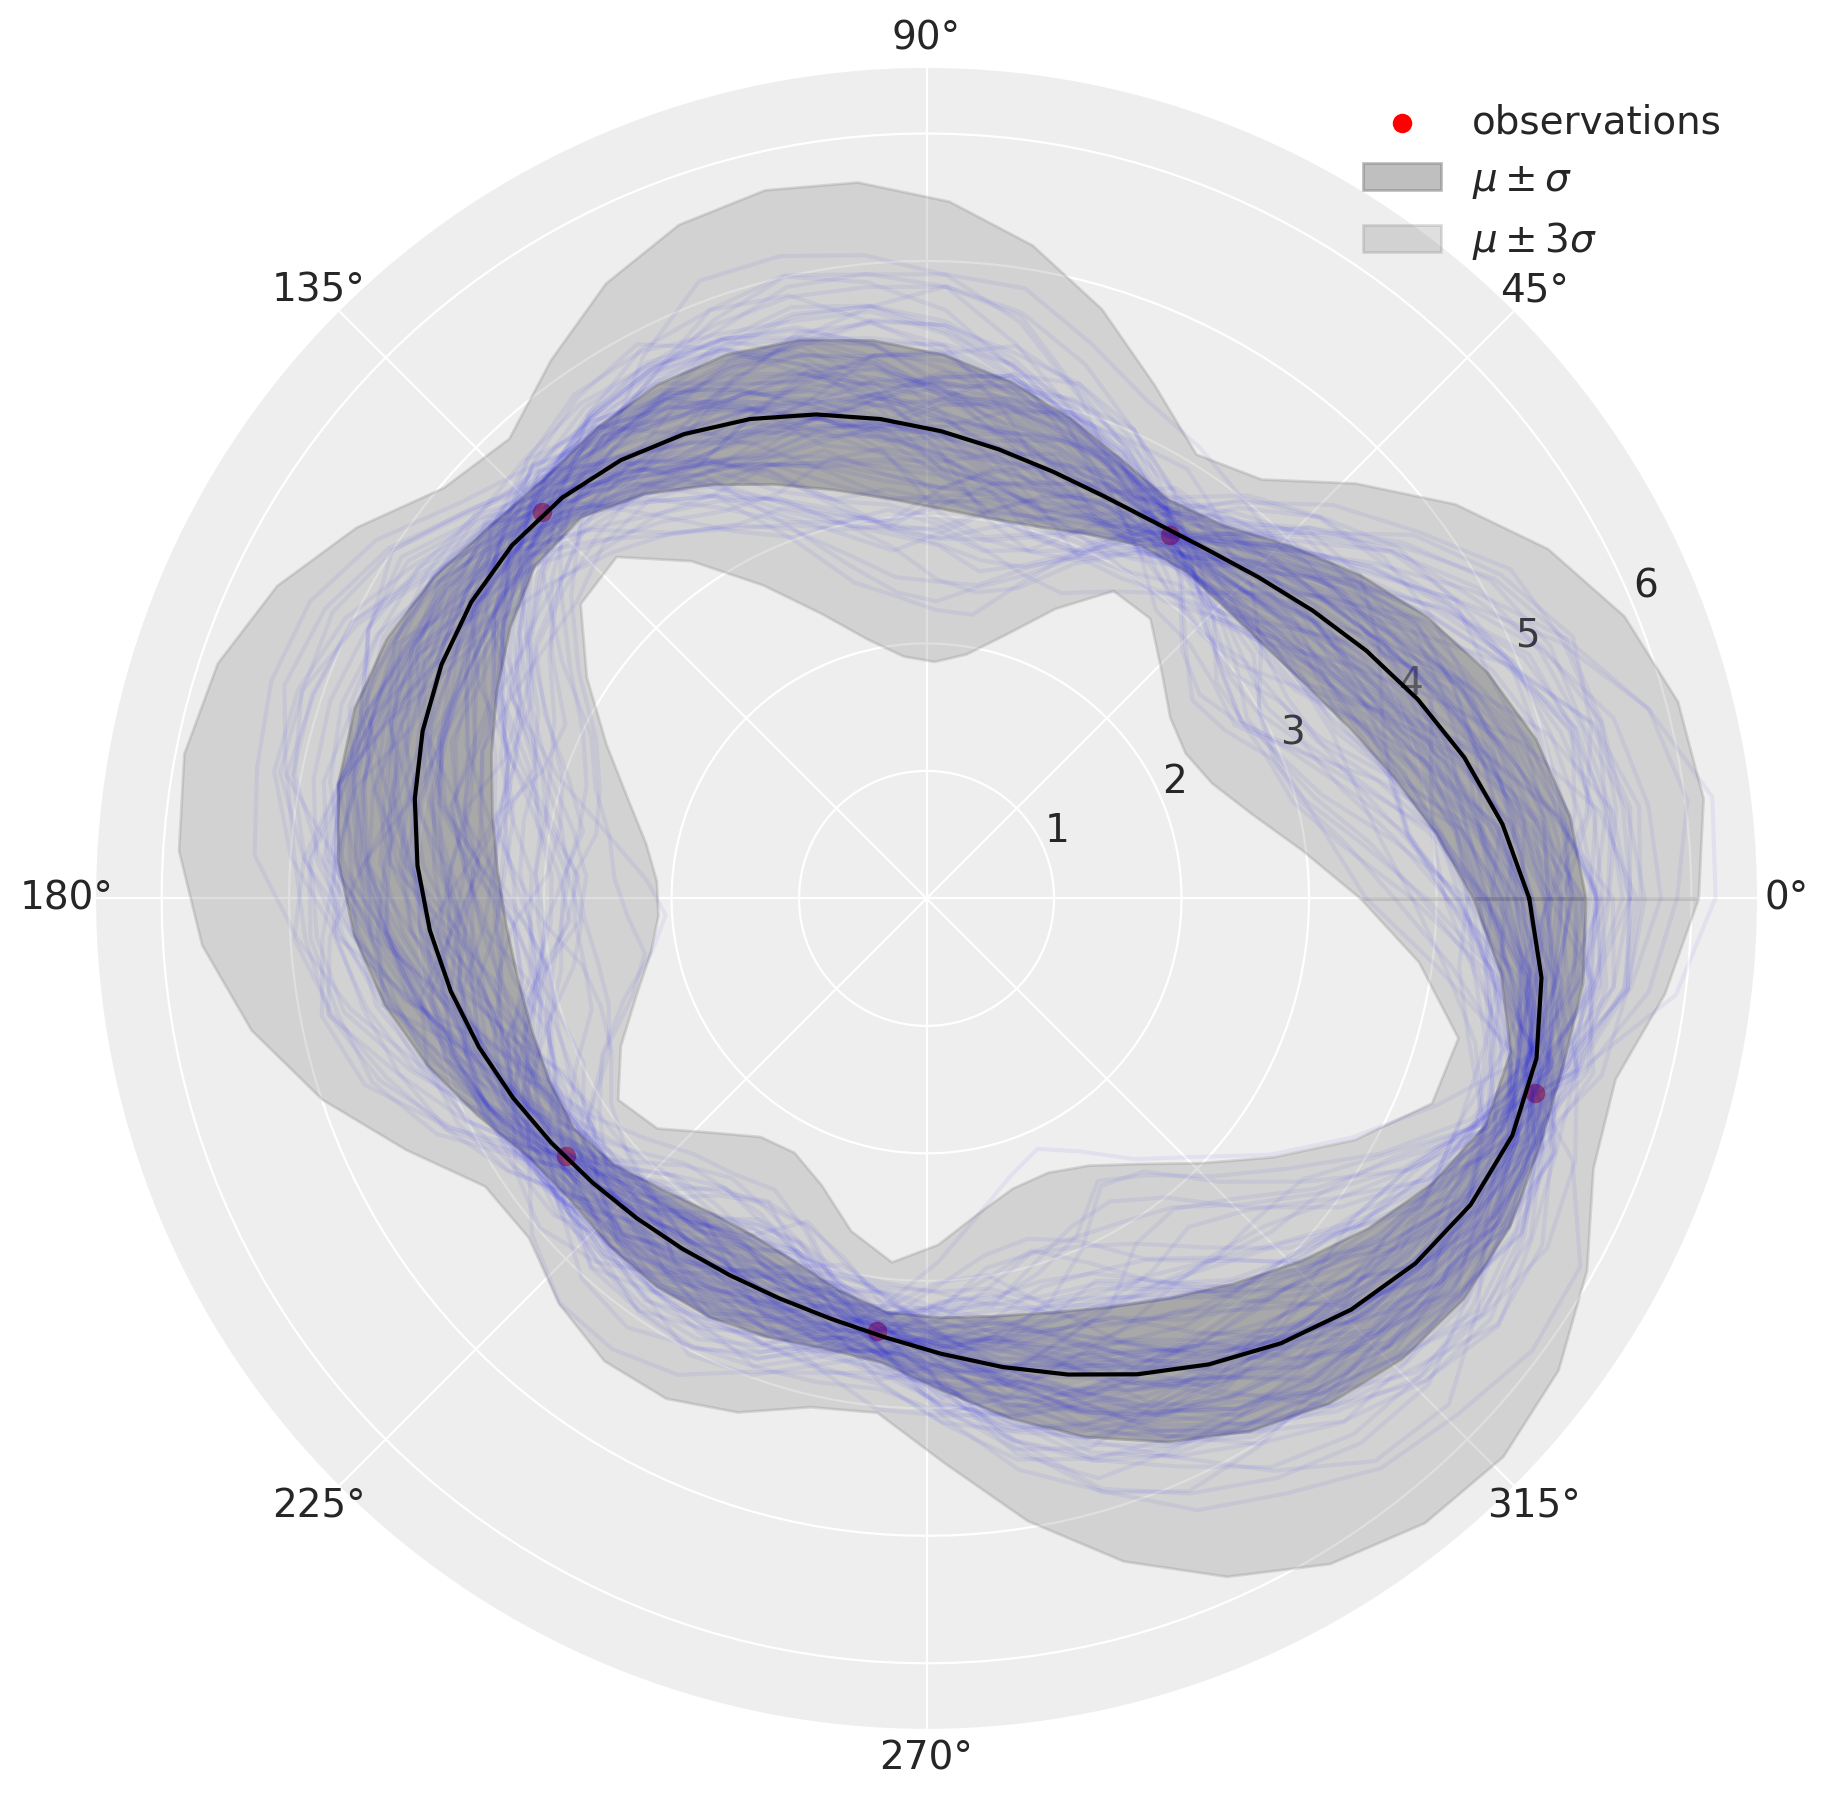

In [10]:
plot_kernel_results(circular)

An alternative solution is Periodic kernel.

**Note**:

* In Periodic kernel, the key parameter to control for correlation between points is `ls`
* In Circular kernel it is `tau`, adding `ls` parameter did not make sense since it cancels out

Basically there is little difference between these kernels, only the way to model correlations. 

In [11]:
def periodic():
    ls = pm.Gamma("ℓ", alpha=2, beta=1)
    return pm.gp.cov.Periodic(1, 2 * np.pi, ls=ls)

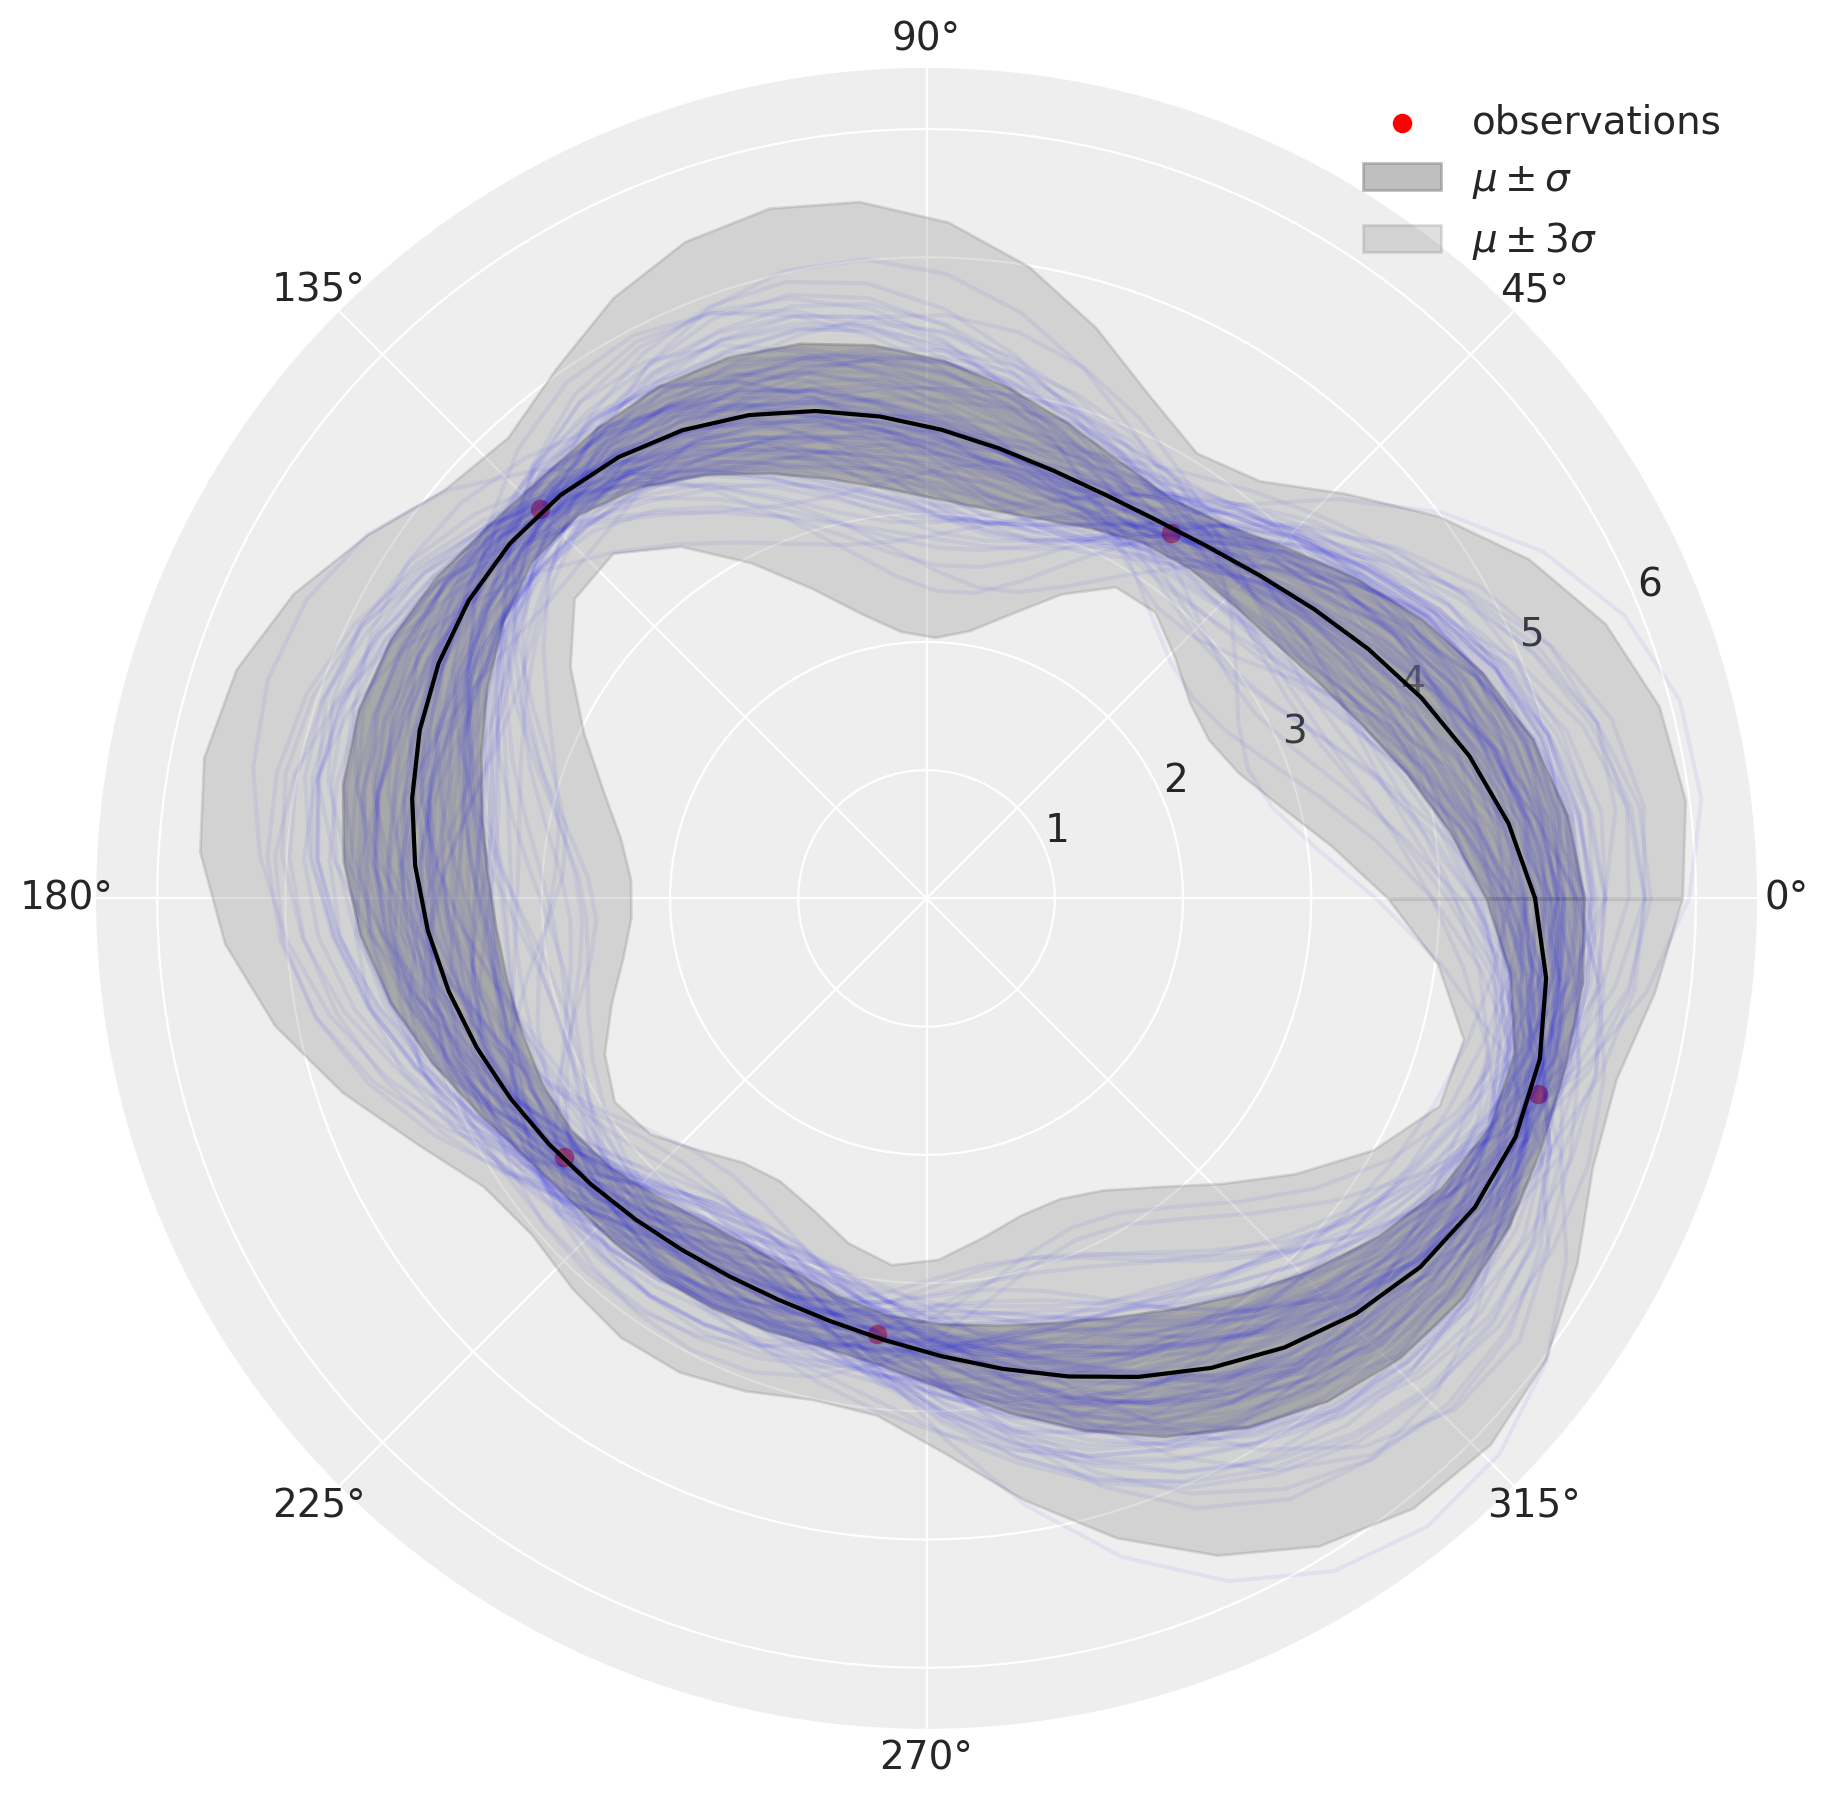

In [12]:
plot_kernel_results(periodic)

From the simulation, we see that **Circular kernel leads to a more uncertain posterior.**

Let's see how Exponential kernel fails

In [13]:
def rbf():
    ls = pm.Gamma("ℓ", alpha=2, beta=1)
    return pm.gp.cov.Exponential(1, ls=ls)

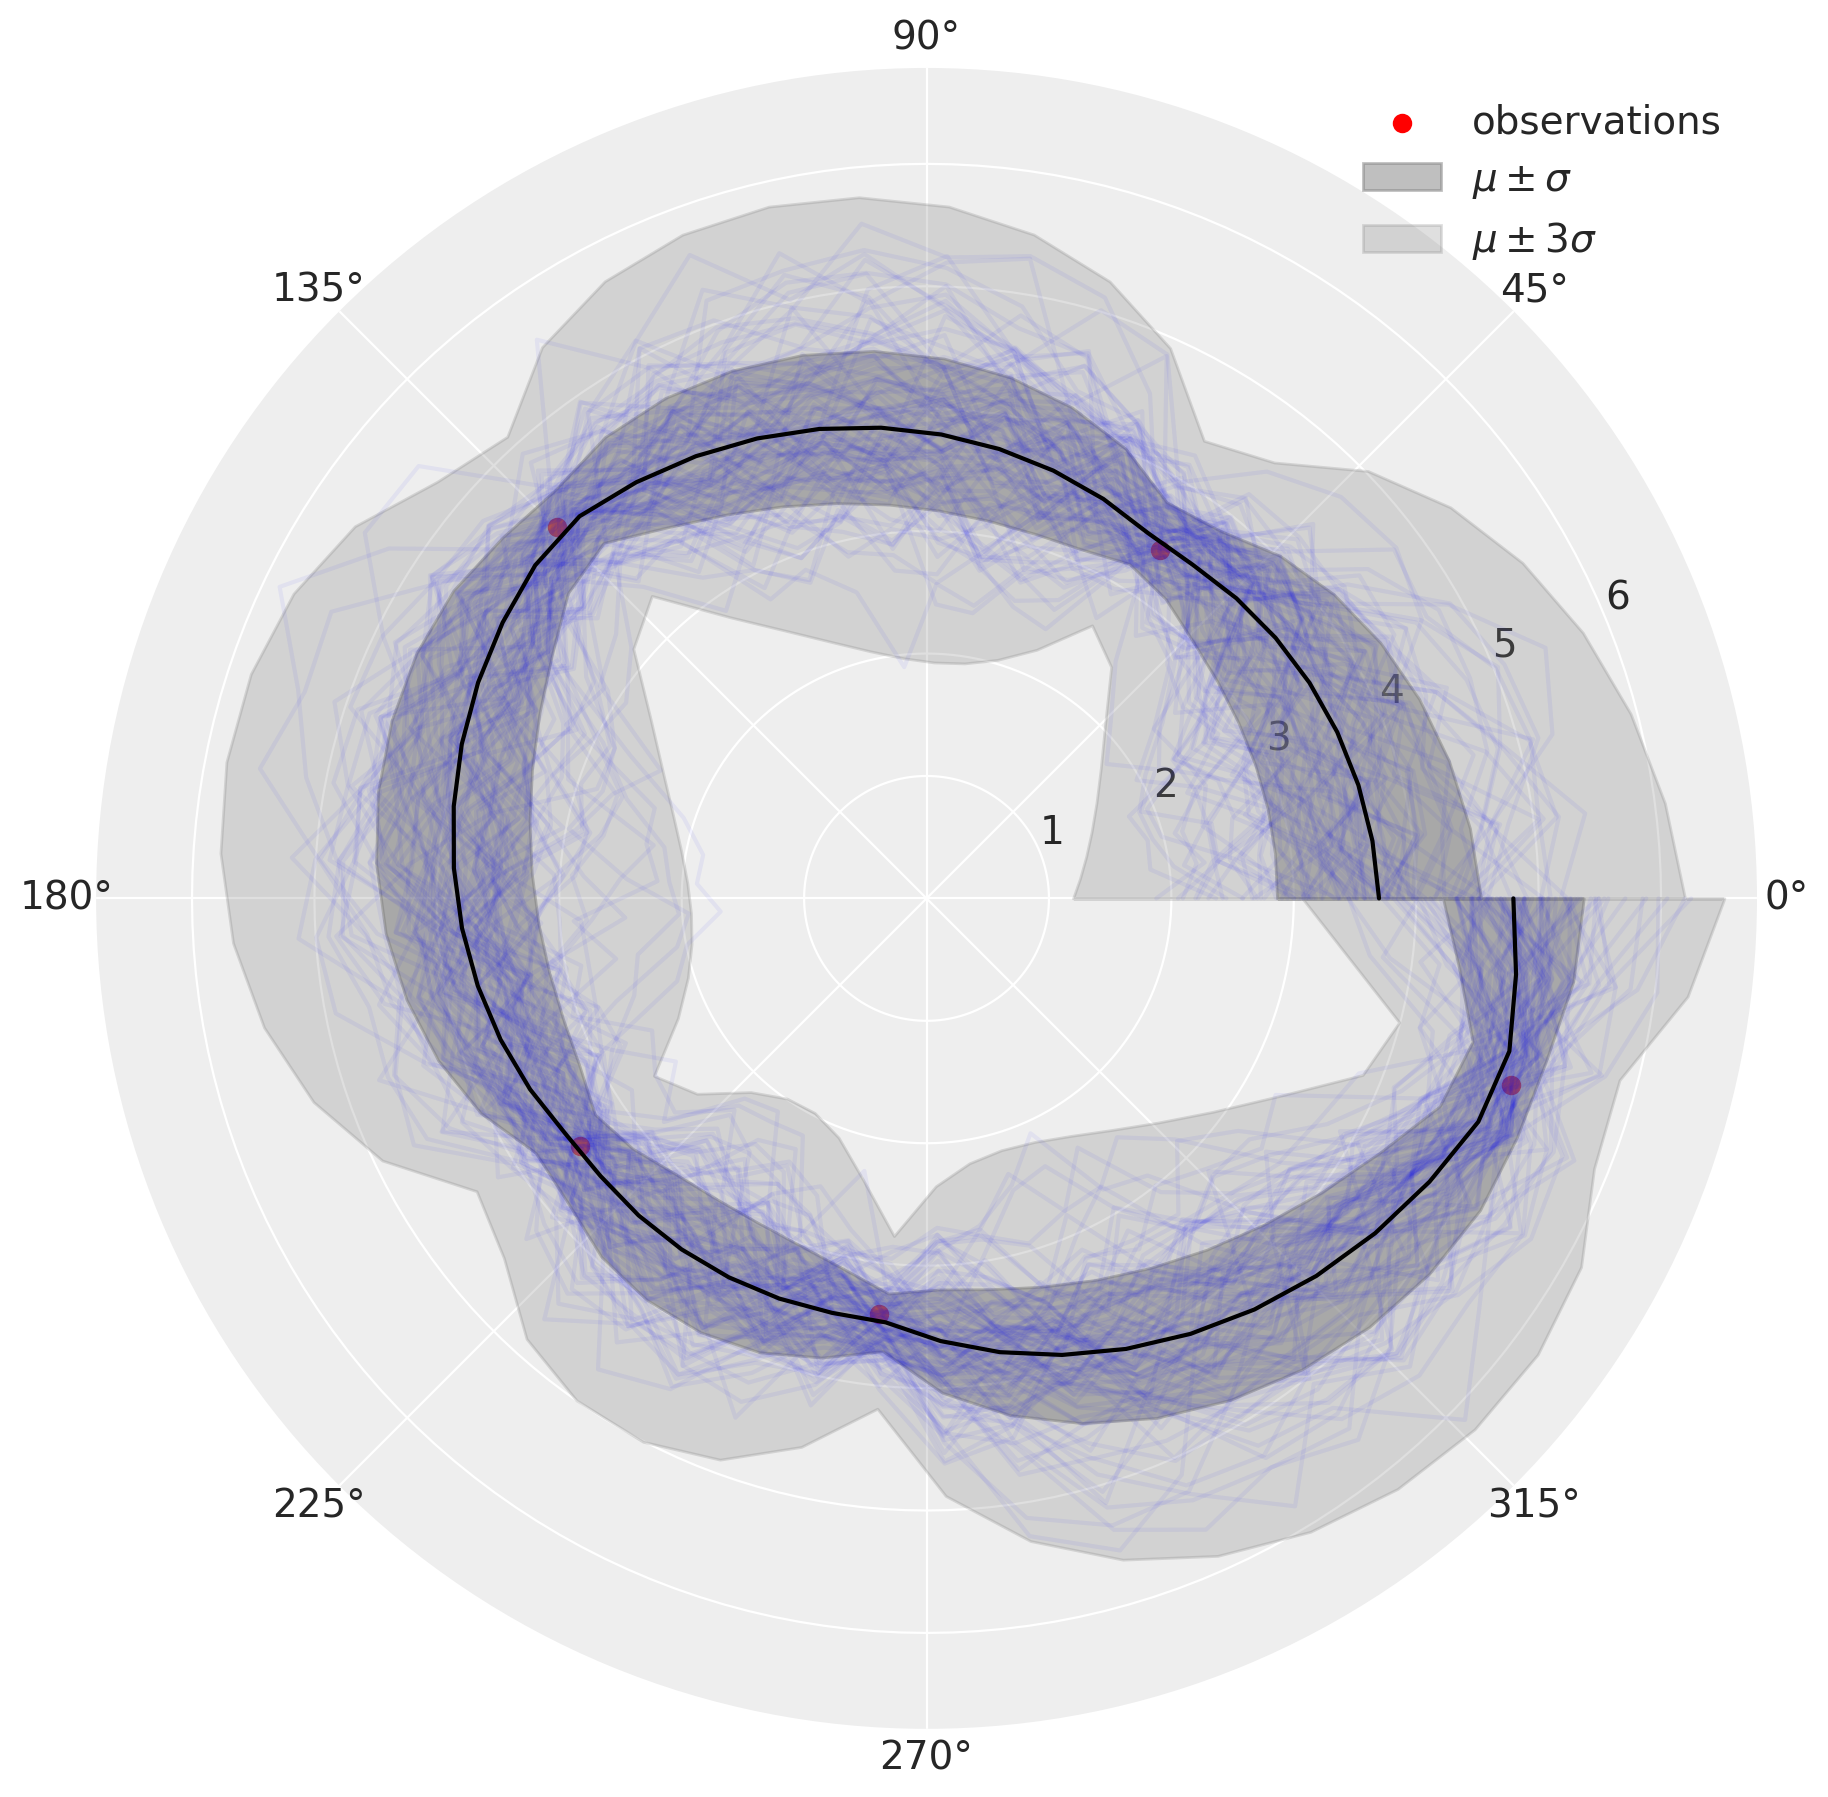

In [14]:
plot_kernel_results(rbf)

The results look similar to what we had with Circular kernel, but the change point $0^\circ$ is not taken in account

## Conclusions

* Use circular/periodic kernel once you strongly believe function should smoothly go through the boundary of the cycle
* Periodic kernel is as fine as Circular except that the latter allows more uncertainty 
* RBF kernel is not the right choice

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.9.3
numpy 1.19.0
arviz 0.9.0
last updated: Sat Oct 10 2020 

CPython 3.8.6
IPython 7.17.0
watermark 2.0.2
